In [1]:
# 加载画图包
%config InlineBackend.figure_format = 'retina'

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.font_manager as font_manager
import matplotlib as mpl
import matplotlib.patches as mp
import seaborn as sns

# 设置全局字体
font_dirs = ["/public/home/mowp/test/fonts/"]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    
plt.rcParams["font.family"] = "Arial"
plt.rcParams['font.size'] = 12
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
import pysam
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu, ttest_ind
from legendkit import legend

In [3]:
import sys
sys.path.append('/public1/mowp/workspace/nanopore_modification/scripts/')

%load_ext autoreload
%autoreload 1
%aimport single_read_plot

In [4]:
infile = '/data/Zhaijx/mowp/db/col-CEN/bed/tel_region.bed'
tel_region = {}
with open(infile) as f:
    for line in f:
        line = line.strip().split('\t')
        tel_region[line[3]] = (line[0], int(line[1]), int(line[2]))

In [5]:
# threshold = 0.9

infiles = {
    'ddcc':[
        '/data/Zhaijx/mowp/data/stam_seq_col_CEN/20220903_ddcc_m6A/6ma_results/20220903_ddcc_m6A.6mA_genome_pos.tsv.gz',
        '/data/Zhaijx/mowp/data/stam_seq_col_CEN/test/20220903_ddcc_m6.5mC_genome_pos.tsv.gz'
    ],
    'met1-3':[
        '/data/Zhaijx/mowp/data/stam_seq_col_CEN/20220923_met1-3_m6A_2/6ma_results/20220924_met1-3.6mA_genome_pos.tsv.gz',
        '/data/Zhaijx/mowp/data/stam_seq_col_CEN/test/20220924_met1-3.5mC_genome_pos.tsv.gz'
    ],
    'wt1029':[
        '/data/Zhaijx/mowp/data/stam_seq_col_CEN/20221029_col_m6A/6ma_results/20221029_col_m6A.6mA_genome_pos.tsv.gz',
        '/data/Zhaijx/mowp/data/stam_seq_col_CEN/test/20221029_col_m6A.5mC_genome_pos.tsv.gz',
    ],
    'wt1208':[
        '/data/Zhaijx/mowp/data/stam_seq_col_CEN/20221208_col_m6A/6ma_results/20221208_col_m6A.6mA_genome_pos.tsv.gz',
        '/data/Zhaijx/mowp/data/stam_seq_col_CEN/test/20221208_col_m6A.5mC_genome_pos.tsv.gz',
    ],
    'wt1005':[
        '/data/Zhaijx/mowp/data/stam_seq_col_CEN/20221005_col_shoot/6ma_results/20221005_col_shoot.6mA_genome_pos.tsv.gz',
        '/data/Zhaijx/mowp/data/stam_seq_col_CEN/test/20221005_col_shoot.5mC_genome_pos.tsv.gz',
    ],
}

In [6]:
bamfiles = {
    'wt1029': '/data/Zhaijx/mowp/data/stam_seq_col_CEN/20221029_col_m6A/aligned_data/20221029_col_m6A.sorted.q2.bam',
    'wt1208': '/data/Zhaijx/mowp/data/stam_seq_col_CEN/20221208_col_m6A/aligned_data/20221208_col_m6A.sorted.q2.bam',
    'ddcc': '/data/Zhaijx/mowp/data/stam_seq_col_CEN/20220903_ddcc_m6A/aligned_data/20220903_ddcc_m6A.sorted.q2.bam',
    'met1-3': '/data/Zhaijx/mowp/data/stam_seq_col_CEN/20220923_met1-3_m6A_2/aligned_data/20220924_met1-3.sorted.q2.bam',
    'wt1005': '/data/Zhaijx/mowp/data/stam_seq_col_CEN/20221005_col_shoot/aligned_data/20221005_col_shoot.sorted.q2.bam',
}

In [7]:
def get_tel_region_pos(tel_name, extend: int = 2000):
    chrom, start, end = tel_region[tel_name]
    if tel_name[-1] == 'L':
        return chrom, start, end+extend
    else:
        return chrom, start-extend, end

In [8]:
def subtelomere_methylation(infile: str, label: str, read_set: set =None, downstream: int=1000):
    """
    Calculate methylation ratios for subtelomere regions.

    Parameters
    ----------
    infile : str
        Path to input file.
    label : str
        Label.
    downstream : int, optional
        Downstream region size for subtelomeres.

    Returns
    -------
    pandas.DataFrame
        Data frame containing the resulting methylation ratios.

    Raises
    ------
    ValueError
        If telomere name is invalid.
    """
    tbx = pysam.TabixFile(infile)

    results = []
    for tel in tel_region:
        chrom, start, end = tel_region[tel]
        if tel[-1] == 'L':
            subtel_start = end
            subtel_end = end + downstream
        else:
            subtel_start = start - downstream
            subtel_end = start
        
        # print(tel, chrom, subtel_start, subtel_end)

        for line in tbx.fetch(chrom, subtel_start, subtel_end):
            read_id, mod, _chrom, _start, _end, strand, methylated_pos, unmethylated_pos = line.split('\t')

            # filter low mapq reads
            if read_set is not None and read_id not in read_set:
                continue

            _start = int(_start)
            _end = int(_end)

            # read that is not fully covered by the subtelomere
            if _start > subtel_start or _end < subtel_end:
                continue
            
            # strand type
            if tel[-1] == 'L':
                strand_type = 'C-rich' if strand == '+' else 'G-rich'
            elif tel[-1] == 'R':
                strand_type = 'G-rich' if strand == '+' else 'C-rich'
            else:
                raise ValueError('telomere name error')

            methylated_pos = np.fromstring(methylated_pos, sep=',', dtype=int)
            unmethylated_pos = np.fromstring(unmethylated_pos, sep=',', dtype=int)

            methylated_n = len(methylated_pos[(methylated_pos >= subtel_start) & (methylated_pos <= subtel_end)])
            unmethylated_n = len(unmethylated_pos[(unmethylated_pos >= subtel_start) & (unmethylated_pos <= subtel_end)])
            if methylated_n + unmethylated_n > 1:  # 5
                methylation_ratio = methylated_n / (methylated_n + unmethylated_n)
                results.append((tel, methylation_ratio, methylated_n, methylated_n + unmethylated_n, strand_type, label))

    tbx.close()

    data = pd.DataFrame(results, columns=['tel_name', 'methylation_ratio', 'm_count', 'total_count', 'strand', 'label'])
    return data

In [9]:
def get_read_set(name):
    read_set = set()
    for tel in tel_region:
        chrom, start, end = get_tel_region_pos(tel)
        _read_set = single_read_plot.preprocessing(infiles[name],  (0, 1), chrom, start, end, bam=bamfiles[name])
        read_set.update(_read_set)

    print(len(read_set))
    return read_set

## CG methylation

### WT

In [10]:
name = 'wt1208'
wt_read_set = get_read_set(name)

2444


In [11]:
infile = infiles[name][1].replace('5mC', 'CG')
wt_mcg = subtelomere_methylation(infile, 'WT', read_set=wt_read_set)

In [12]:
name = 'wt1005'
wt1005_read_set = get_read_set(name)

1476


In [13]:
infile = infiles[name][1].replace('5mC', 'CG')
wt1005_mcg = subtelomere_methylation(infile, 'WT1005', read_set=wt1005_read_set)

### met1-3

In [14]:
name = 'met1-3'
met13_read_set = get_read_set(name)

1166


In [15]:
infile = infiles[name][1].replace('5mC', 'CG')
met13_mcg = subtelomere_methylation(infile, 'met1-3', read_set=met13_read_set)

### ddcc

In [16]:
name = 'ddcc'
ddcc_read_set = get_read_set(name)

1912


In [17]:
infile = infiles[name][1].replace('5mC', 'CG')
ddcc_mcg = subtelomere_methylation(infile, 'ddcc', read_set=ddcc_read_set)

## CHG methylation

### WT

In [18]:
name = 'wt1208'
wt_read_set = get_read_set(name)

2444


In [19]:
infile = infiles[name][1].replace('5mC', 'CHG')
wt_mchg = subtelomere_methylation(infile, 'WT', read_set=wt_read_set)

In [20]:
name = 'wt1005'
wt1005_read_set = get_read_set(name)

1476


In [21]:
infile = infiles[name][1].replace('5mC', 'CHG')
wt1005_mchg = subtelomere_methylation(infile, 'WT1005', read_set=wt1005_read_set)

### met1-3

In [22]:
name = 'met1-3'
met13_read_set = get_read_set(name)

1166


In [23]:
infile = infiles[name][1].replace('5mC', 'CHG')
met13_mchg = subtelomere_methylation(infile, 'met1-3', read_set=met13_read_set)

### ddcc

In [24]:
name = 'ddcc'
ddcc_read_set = get_read_set(name)

1912


In [25]:
infile = infiles[name][1].replace('5mC', 'CHG')
ddcc_mchg = subtelomere_methylation(infile, 'ddcc', read_set=ddcc_read_set)

## CHH methylation

### WT

In [26]:
name = 'wt1208'
wt_read_set = get_read_set(name)

2444


In [27]:
infile = infiles[name][1].replace('5mC', 'CHH')
wt_mchh = subtelomere_methylation(infile, 'WT', read_set=wt_read_set)

In [28]:
name = 'wt1005'
wt1005_read_set = get_read_set(name)

1476


In [29]:
infile = infiles[name][1].replace('5mC', 'CHH')
wt1005_mchh = subtelomere_methylation(infile, 'WT1005', read_set=wt1005_read_set)

### met1-3

In [30]:
name = 'met1-3'
met13_read_set = get_read_set(name)

1166


In [31]:
infile = infiles[name][1].replace('5mC', 'CHH')
met13_mchh = subtelomere_methylation(infile, 'met1-3', read_set=met13_read_set)

### ddcc

In [32]:
name = 'ddcc'
ddcc_read_set = get_read_set(name)

1912


In [33]:
infile = infiles[name][1].replace('5mC', 'CHH')
ddcc_mchh = subtelomere_methylation(infile, 'ddcc', read_set=ddcc_read_set)

## Accessibility

### WT

In [34]:
name = 'wt1208'
wt_read_set = get_read_set(name)

2444


In [35]:
infile = infiles[name][0]
wt_6ma = subtelomere_methylation(infile, 'WT', read_set=wt_read_set)

In [36]:
name = 'wt1005'
wt1005_read_set = get_read_set(name)

1476


In [37]:
infile = infiles[name][0]
wt1005_6ma = subtelomere_methylation(infile, 'WT1005', read_set=wt1005_read_set)

### met1-3

In [38]:
name = 'met1-3'
met13_read_set = get_read_set(name)

1166


In [39]:
infile = infiles[name][0]
met13_6ma = subtelomere_methylation(infile, 'met1-3', read_set=met13_read_set)

### ddcc

In [40]:
name = 'ddcc'
ddcc_read_set = get_read_set(name)

1912


In [41]:
infile = infiles[name][0]
ddcc_6ma = subtelomere_methylation(infile, 'ddcc', read_set=ddcc_read_set)

# Analysis

mCG	5.526715841986336e-114
mCHG	7.47190225246855e-62
mCHH	0.00042117669483699273
Accessibility	0.3676151907393307


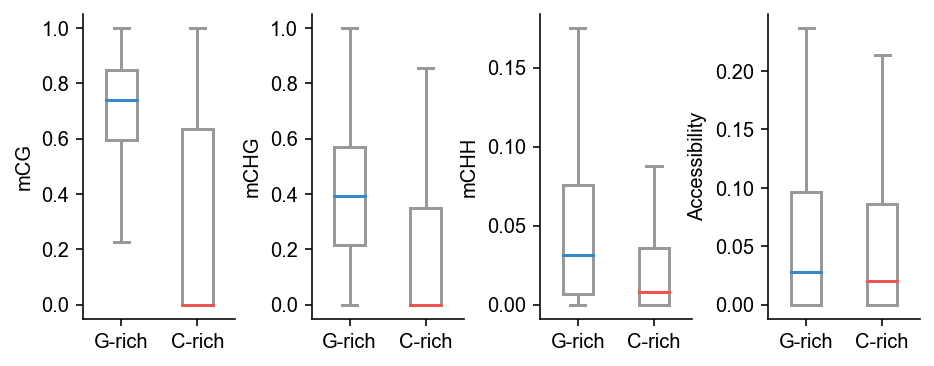

In [43]:
plt.rcParams['font.size'] = 10

fig, axex = plt.subplots(1, 4, figsize=(7.5, 2.8))
datas = (wt_mcg, wt_mchg, wt_mchh, wt_6ma)
ylabels = ('mCG', 'mCHG', 'mCHH', 'Accessibility')

for n, (data, ylabel) in enumerate(zip(datas, ylabels)):
    # i = n // 2
    # j = n % 2
    ax = axex[n]
    sns.boxplot(
        y='methylation_ratio', x='strand', data=data,
        showfliers=False, width=.4, ax=ax, color='white', saturation=1,
        medianprops={'color': '#338aca', 'label': '_median_'},
        # boxprops={'facecolor':'none', 'edgecolor':'black'},
        # whiskerprops={'color':'black'},
        # capprops={'color':'black'}
        )

    median_colors = ['#338aca', '#EB5552']
    median_lines = [line for line in ax.get_lines() if line.get_label() == '_median_']
    for i, line in enumerate(median_lines):
        line.set_color(median_colors[i % len(median_colors)])
    
    _data1 = data.query('strand == "G-rich"')
    _data2 = data.query('strand == "C-rich"')
    u, p = ttest_ind(_data1['methylation_ratio'], _data2['methylation_ratio'])
    print(f'{ylabel}\t{p}')
    
    ax.set_ylabel(ylabel)
    ax.set_xlabel('')
    ax.set_xticklabels(['G-rich', 'C-rich'])
    sns.despine(ax=ax)

plt.subplots_adjust(wspace=.5, hspace=.5)

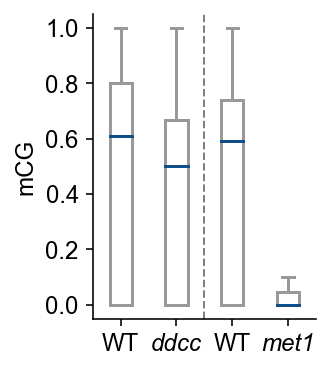

In [44]:
plt.rcParams['font.size'] = 12
data = pd.concat((wt_mcg, ddcc_mcg, wt1005_mcg, met13_mcg), axis=0)

plt.figure(figsize=(2, 2.8))
sns.boxplot(
    y='methylation_ratio', x='label', data=data, 
    showfliers=False, color='white', saturation=1,
    medianprops={'color': '#104e8b'},
    width=.4)

plt.xlabel('')
plt.ylabel('mCG')
sns.despine()

ax = plt.gca()
ax.set_xticklabels(['WT', 'ddcc', 'WT', 'met1'], fontstyle='italic')
labels = ax.get_xticklabels()

for i in (0, 2):
    labels[i].set_style('normal')

plt.axvline(1.5, color='grey', linestyle='--', linewidth=1)

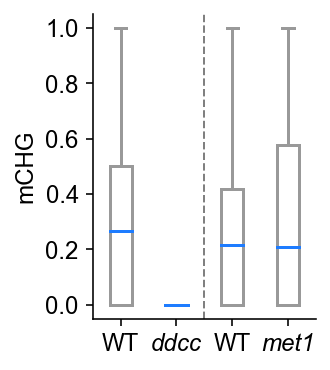

In [45]:
plt.rcParams['font.size'] = 12
data = pd.concat((wt_mchg, ddcc_mchg, wt1005_mchg, met13_mchg), axis=0)

plt.figure(figsize=(2, 2.8))
sns.boxplot(
    y='methylation_ratio', x='label', data=data, 
    showfliers=False, color='white', saturation=1,
    medianprops={'color': '#1e7cff'},
    width=.4)

plt.xlabel('')
plt.ylabel('mCHG')
sns.despine()

ax = plt.gca()
ax.set_xticklabels(['WT', 'ddcc', 'WT', 'met1'], fontstyle='italic')
labels = ax.get_xticklabels()

for i in (0, 2):
    labels[i].set_style('normal')

plt.axvline(1.5, color='grey', linestyle='--', linewidth=1)

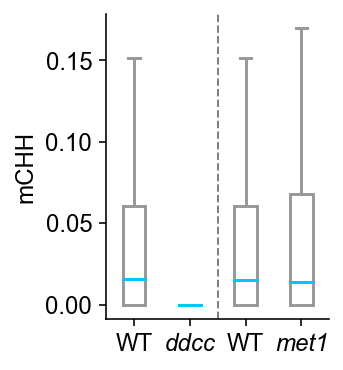

In [46]:
plt.rcParams['font.size'] = 12
data = pd.concat((wt_mchh, ddcc_mchh, wt1005_mchh, met13_mchh), axis=0)

plt.figure(figsize=(2, 2.8))
sns.boxplot(
    y='methylation_ratio', x='label', data=data, 
    showfliers=False, color='white', saturation=1,
    medianprops={'color': '#03c4ff'},
    width=.4)

plt.xlabel('')
plt.ylabel('mCHH')
sns.despine()

ax = plt.gca()
ax.set_xticklabels(['WT', 'ddcc', 'WT', 'met1'], fontstyle='italic')
labels = ax.get_xticklabels()

for i in (0, 2):
    labels[i].set_style('normal')

plt.axvline(1.5, color='grey', linestyle='--', linewidth=1)

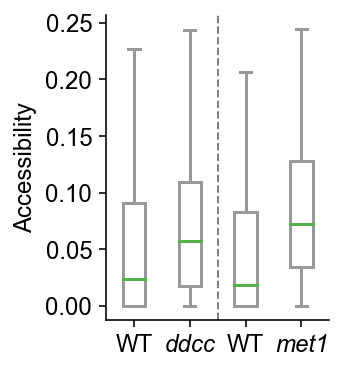

In [47]:
plt.rcParams['font.size'] = 12
data = pd.concat((wt_6ma, ddcc_6ma, wt1005_6ma, met13_6ma), axis=0)

plt.figure(figsize=(2, 2.8))
sns.boxplot(
    y='methylation_ratio', x='label', data=data, 
    showfliers=False, color='white', saturation=1,
    medianprops={'color': '#52af4c'},
    width=.4)

plt.xlabel('')
plt.ylabel('Accessibility')
sns.despine()

ax = plt.gca()
ax.set_xticklabels(['WT', 'ddcc', 'WT', 'met1'], fontstyle='italic')
labels = ax.get_xticklabels()

for i in (0, 2):
    labels[i].set_style('normal')

plt.axvline(1.5, color='grey', linestyle='--', linewidth=1)